# Atmospheric, oceanic and land data handling

In this notebook we discuss the subtleties of how NetCDF-SCM handles different data 'realms' and why these choices are made. The realms of intereset to date are atmosphere, ocean and land and the distinction between the realms follows the [CMIP6 realm controlled vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs/blob/master/CMIP6_realm.json).

In [1]:
import traceback
from os.path import join

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube
from netcdf_scm.utils import broadcast_onto_lat_lon_grid

<IPython.core.display.Javascript object>

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("bmh")

In [3]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel(logging.WARNING)
root_logger.addHandler(logging.StreamHandler())

In [4]:
DATA_PATH_TEST = join("..", "tests", "test-data")

Note that all of our data is on a regular grid, data on native model grids does not plot as nicely.

In [5]:
tas_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "IPSL",
    "IPSL-CM6A-LR",
    "historical",
    "r1i1p1f1",
    "Amon",
    "tas",
    "gr",
    "v20180803",
    "tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_191001-191003.nc"
)

gpp_file = tas_file.replace(
    "Amon", "Lmon"
).replace(
    "tas", "gpp"
)
csoilfast_file = gpp_file.replace("gpp", "cSoilFast")

hfds_file = join(
    DATA_PATH_TEST,
    "cmip6output",
    "CMIP6",
    "CMIP",
    "NOAA-GFDL",
    "GFDL-CM4",
    "piControl",
    "r1i1p1f1",
    "Omon",
    "hfds",
    "gr",
    "v20180701",
    "hfds_Omon_GFDL-CM4_piControl_r1i1p1f1_gr_015101-015103.nc"
)

## Oceans

We start by loading our data.

In [6]:
hfds = CMIP6OutputCube()
hfds.load_data_from_path(hfds_file)

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


NetCDF-SCM will assume whether the data is "ocean", "land" or "atmosphere". The assumed realm can be checked by examining a `SCMCube`'s `netcdf_scm_realm` property. 

In our case we have "ocean" data.

In [7]:
hfds.netcdf_scm_realm

'ocean'

If we have ocean data, then there is no data which will go in a "land" box. Hence, if we request e.g. `World|Land` data, an error will be raised.

In [8]:
try:
    hfds.get_scm_timeseries(regions=["World", "World|Land"])
except ValueError as e:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: All weights are zero for region: `World|Land`


As there is no land data, the `World` mean is equal to the `World|Ocean` mean.

Not calculating land fractions as all required cubes are not available
Performing lazy conversion to datetime for calendar: 365_day. This may cause subtle errors in operations that depend on the length of time between dates
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


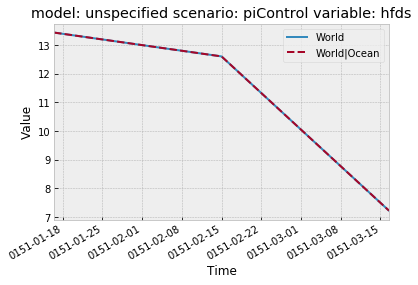

In [9]:
hfds_scm_ts = hfds.get_scm_timeseries(
    regions=["World", "World|Ocean"]
)
hfds_scm_ts.line_plot(linestyle="region")
np.testing.assert_allclose(
    hfds_scm_ts.filter(region="World").values,
    hfds_scm_ts.filter(region="World|Ocean").values,
);

When taking averages, there are 3 obvious options:

- unweighted average
- area weighted average
- area and surface fraction weighted average

In NetCDF-SCM, we always go for the third type in order to make sure that our weights are both area weighted and take into account how much each cell represents the SCM box of interest.

In the cells below, we show the difference this choice makes.

In [10]:
def compare_weighting_options(input_scm_cube):
    unweighted_mean = input_scm_cube.cube.collapsed(
        ["latitude", "longitude"],
        iris.analysis.MEAN
    )
    
    area_cell = input_scm_cube.get_metadata_cube(
        input_scm_cube.areacell_var
    ).cube

    area_weights = broadcast_onto_lat_lon_grid(
        input_scm_cube, 
        area_cell.data
    )
    area_weighted_mean= input_scm_cube.cube.collapsed(
        ["latitude", "longitude"],
        iris.analysis.MEAN,
        weights=area_weights
    )
    
    surface_frac = input_scm_cube.get_metadata_cube(
        input_scm_cube.surface_fraction_var
    ).cube

    
    area_sf = area_cell * surface_frac
    area_sf_weights = broadcast_onto_lat_lon_grid(
        input_scm_cube, 
        area_sf.data
    )
    area_sf_weighted_mean = input_scm_cube.cube.collapsed(
        ["latitude", "longitude"],
        iris.analysis.MEAN,
        weights=area_sf_weights
    )
    
    plt.figure(figsize=(8, 4.5))
    qplt.plot(unweighted_mean, label="unweighted")
    qplt.plot(area_weighted_mean, label="area weighted")
    qplt.plot(
        area_sf_weighted_mean, 
        label="area-surface fraction weighted", 
        linestyle="--",
        dashes=(10, 10),
        linewidth=4
    )

    plt.legend();

Collapsing spatial coordinate 'latitude' without weighting


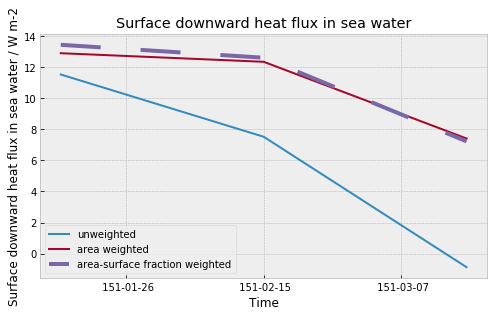

In [11]:
compare_weighting_options(hfds)

We go to the trouble of taking these area-surface fraction weightings because they matter. In particular, the area weight is required to not overweight the poles (on whatever grid we're working) whilst the surface fraction ensures that the cells' contribution to the averages reflects how much they belong in a given 'SCM box'.

### More detail

We can check which variable is being used for the cell areas by loooking at `SCMCube.areacell_var`. For ocean data this is `areacello`.

In [12]:
hfds.areacell_var

'areacello'

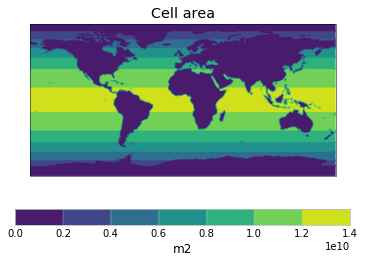

In [13]:
hfds_area_cell = hfds.get_metadata_cube(hfds.areacell_var).cube
qplt.contourf(
    hfds_area_cell,
);

We can check which variable is being used for the surface fraction by loooking at `SCMCube.surface_fraction_var`. For ocean data this is `sftof`.

In [14]:
hfds.surface_fraction_var

'sftof'

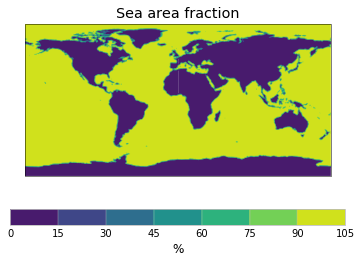

In [15]:
hfds_surface_frac = hfds.get_metadata_cube(hfds.surface_fraction_var).cube
qplt.contourf(
    hfds_surface_frac,
);

The product of the area of the cells and the surface fraction gives us the area-surface fraction weights.

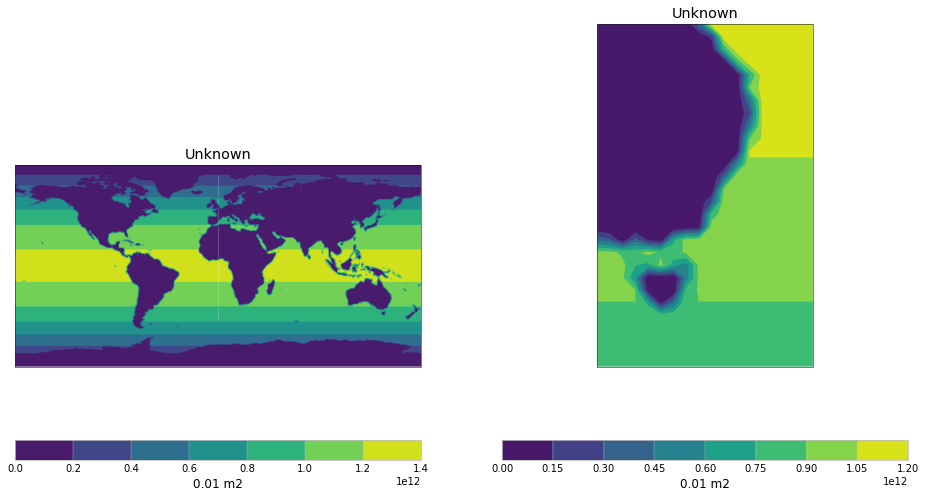

In [16]:
hfds_area_sf = hfds_area_cell * hfds_surface_frac

plt.figure(figsize=(16, 9))
plt.subplot(121)
qplt.contourf(
    hfds_area_sf,
)

plt.subplot(122)
lat_con = iris.Constraint(latitude=lambda cell: -50 < cell < -20)
lon_con = iris.Constraint(longitude=lambda cell: 140 < cell < 160)
qplt.contourf(
    hfds_area_sf.extract(lat_con & lon_con),
);

The timeseries calculated by NetCDF-SCM is the same as the timeseries calculated using the surface fraction and area weights.

In [17]:
hfds_area_sf_weights = broadcast_onto_lat_lon_grid(
    hfds, 
    hfds_area_sf.data
)
hfds_area_sf_weighted_mean = hfds.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=hfds_area_sf_weights
)

netcdf_scm_calculated = hfds.get_scm_timeseries(
    regions=["World"]
).timeseries()

np.testing.assert_allclose(
    hfds_area_sf_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze()
)

netcdf_scm_calculated.T

Not calculating land fractions as all required cubes are not available
Performing lazy conversion to datetime for calendar: 365_day. This may cause subtle errors in operations that depend on the length of time between dates


model,unspecified
scenario,piControl
region,World
variable,hfds
unit,W m^-2
activity_id,CMIP
climate_model,GFDL-CM4
member_id,r1i1p1f1
mip_era,CMIP6
variable_standard_name,surface_downward_heat_flux_in_sea_water
time,


## Land

Next we look at land data.

In [18]:
gpp = CMIP6OutputCube()
gpp.load_data_from_path(gpp_file)

csoilfast = CMIP6OutputCube()
csoilfast.load_data_from_path(csoilfast_file)

In [19]:
gpp.netcdf_scm_realm

'land'

In [20]:
csoilfast.netcdf_scm_realm

'land'

If we have land data, then there is no data which will go in a "ocean" box. Hence, if we request e.g. `World|Ocean` data, an error will be raised.

In [21]:
try:
    gpp.get_scm_timeseries(regions=["World", "World|Ocean"])
except ValueError as e:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: All weights are zero for region: `World|Ocean`


As there is no ocean data, the `World` mean is equal to the `World|Land` mean.

Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
Not calculating land fractions as all required cubes are not available


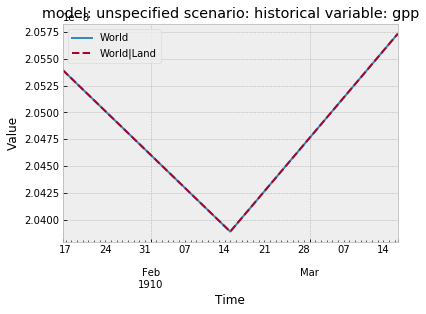

In [22]:
gpp_scm_ts = gpp.get_scm_timeseries(
    regions=["World", "World|Land"]
)
gpp_scm_ts.line_plot(linestyle="region")
np.testing.assert_allclose(
    gpp_scm_ts.filter(region="World").values,
    gpp_scm_ts.filter(region="World|Land").values,
);

Collapsing spatial coordinate 'latitude' without weighting


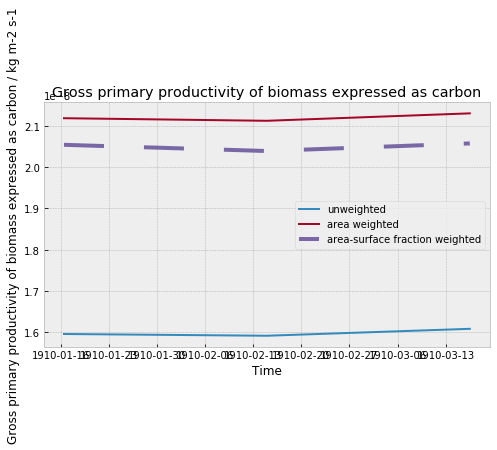

In [23]:
compare_weighting_options(gpp)

Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.


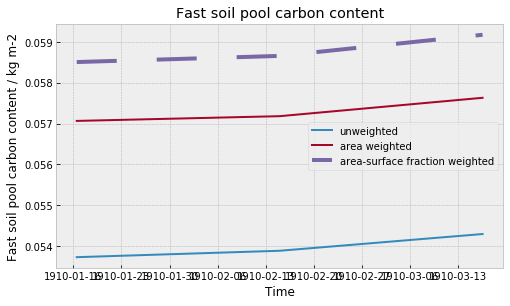

In [24]:
compare_weighting_options(csoilfast)

## Atmosphere

Finally we look at atmospheric data.

In [25]:
tas = CMIP6OutputCube()
tas.load_data_from_path(tas_file)

In [26]:
tas.netcdf_scm_realm

'atmosphere'

If we have atmosphere data, then we have global coverage and so can split data into both the land and ocean boxes.

Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
Not calculating land fractions as all required cubes are not available
Not calculating land fractions as all required cubes are not available
Not calculating land fractions as all required cubes are not available


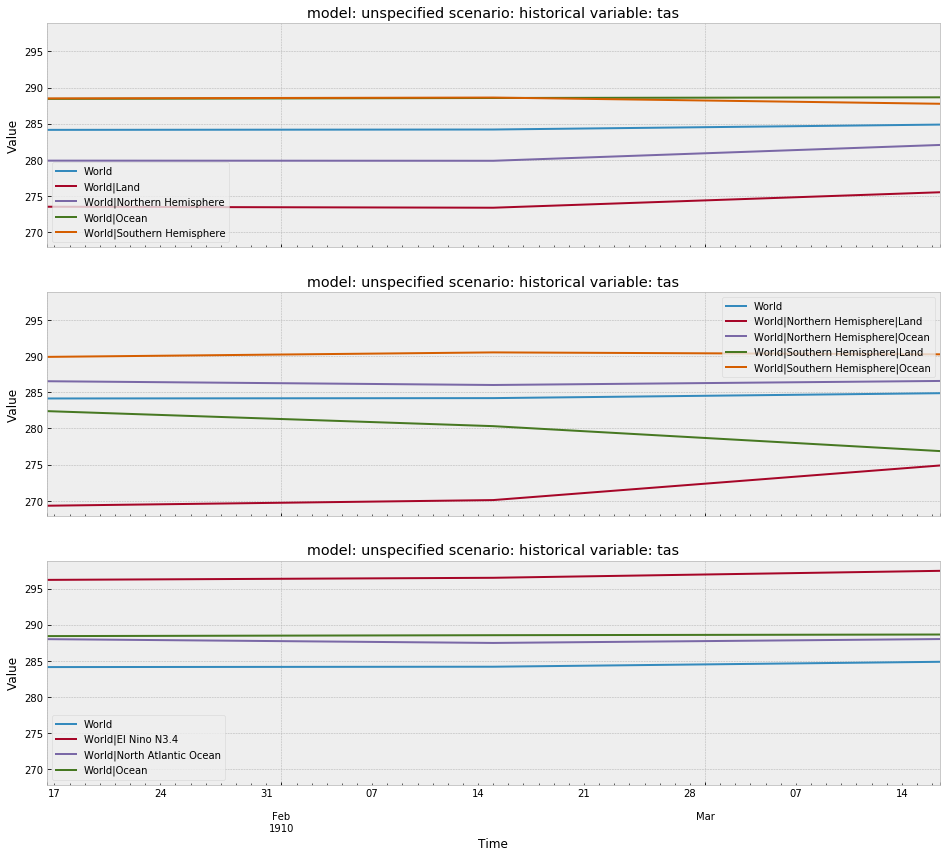

In [27]:
fig = plt.figure(figsize=(16, 14))
ax1 = fig.add_subplot(311)
tas.get_scm_timeseries(
    regions=[
        "World",
        "World|Land",
        "World|Ocean",
        "World|Northern Hemisphere",
        "World|Southern Hemisphere",
    ]
).line_plot(color="region", ax=ax1)

ax2 = fig.add_subplot(312, sharey=ax1, sharex=ax1)
tas.get_scm_timeseries(
    regions=[
        "World",
        "World|Northern Hemisphere|Land",
        "World|Southern Hemisphere|Land",
        "World|Northern Hemisphere|Ocean",
        "World|Southern Hemisphere|Ocean",
    ]
).line_plot(color="region", ax=ax2)

ax3 = fig.add_subplot(313, sharey=ax1, sharex=ax1)
tas.get_scm_timeseries(
    regions=[
        "World",
        "World|Ocean",
        "World|North Atlantic Ocean",
        "World|El Nino N3.4",
    ]
).line_plot(color="region", ax=ax3);

Collapsing spatial coordinate 'latitude' without weighting


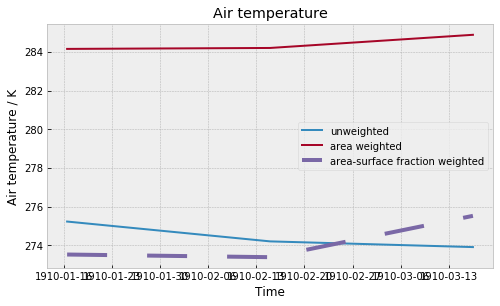

In [28]:
compare_weighting_options(tas)

As our data is global, the "World" data is simply an area-weighted mean.

In [29]:
tas_area = tas.get_metadata_cube(
    tas.areacell_var
).cube

tas_area_weights = broadcast_onto_lat_lon_grid(
    tas, 
    tas_area.data
)
tas_area_weighted_mean = tas.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=tas_area_weights
)

netcdf_scm_calculated = tas.get_scm_timeseries(
    regions=["World"]
).timeseries()

np.testing.assert_allclose(
    tas_area_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze()
)

netcdf_scm_calculated.T

Not calculating land fractions as all required cubes are not available


model,unspecified
scenario,historical
region,World
variable,tas
unit,K
activity_id,CMIP
climate_model,IPSL-CM6A-LR
member_id,r1i1p1f1
mip_era,CMIP6
variable_standard_name,air_temperature
time,


The "World|Land" data is surface fraction weighted.

In [30]:
tas_sf = tas.get_metadata_cube(
    tas.surface_fraction_var
).cube

tas_area_sf = tas_area * tas_sf

tas_area_sf_weights = broadcast_onto_lat_lon_grid(
    tas, 
    tas_area_sf.data
)
tas_area_sf_weighted_mean = tas.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=tas_area_sf_weights
)

netcdf_scm_calculated = tas.get_scm_timeseries(
    regions=["World|Land"]
).timeseries()

np.testing.assert_allclose(
    tas_area_sf_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze()
)

netcdf_scm_calculated.T

Not calculating land fractions as all required cubes are not available


model,unspecified
scenario,historical
region,World|Land
variable,tas
unit,K
activity_id,CMIP
climate_model,IPSL-CM6A-LR
member_id,r1i1p1f1
mip_era,CMIP6
variable_standard_name,air_temperature
time,


The "World|Ocean" data is also surface fraction weighted (calculated as 100 minus land surface fraction).

In [31]:
tas_sf_ocean = tas.get_metadata_cube(
    tas.surface_fraction_var
).cube
tas_sf_ocean.data = 100 - tas_sf_ocean.data

tas_area_sf_ocean = tas_area * tas_sf_ocean

tas_area_sf_ocean_weights = broadcast_onto_lat_lon_grid(
    tas, 
    tas_area_sf_ocean.data
)
tas_area_sf_ocean_weighted_mean = tas.cube.collapsed(
    ["latitude", "longitude"],
    iris.analysis.MEAN,
    weights=tas_area_sf_ocean_weights
)

netcdf_scm_calculated = tas.get_scm_timeseries(
    regions=["World|Ocean"]
).timeseries()

np.testing.assert_allclose(
    tas_area_sf_ocean_weighted_mean.data,
    netcdf_scm_calculated.values.squeeze()
)

netcdf_scm_calculated.T

Not calculating land fractions as all required cubes are not available


model,unspecified
scenario,historical
region,World|Ocean
variable,tas
unit,K
activity_id,CMIP
climate_model,IPSL-CM6A-LR
member_id,r1i1p1f1
mip_era,CMIP6
variable_standard_name,air_temperature
time,
